In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import statsmodels.api as sm
import os
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from esem import gp_model
from esem.utils import get_random_params, leave_one_out, prediction_within_ci
from esem.sampler import MCMCSampler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy import stats
import gpflow

from SALib.sample import fast_sampler
from SALib.analyze import fast

2023-03-15 17:01:20.834744: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 17:01:21.344506: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-15 17:01:21.527318: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-15 17:01:24.400470: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
### import some analysis functions we wrote for this project
import sys ; sys.path.append("..")
import sys ; sys.path.append("../../")
from ppe_analysis.analysis import *

### Start up PBS cluster
 - may need to adjust project and/or walltime

In [4]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='10GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300641', # Input your project ID here
    walltime='01:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(30)

# Setup your client
client = Client(cluster)

Task exception was never retrieved
future: <Task finished name='Task-27' coro=<_wrap_awaitable() done, defined at /glade/u/home/linnia/miniconda3/envs/mlenv/lib/python3.9/asyncio/tasks.py:681> exception=RuntimeError('Command exited with non-zero exit code.\nExit code: -2\nCommand:\nqsub /glade/scratch/linnia/tmpm1cpgxql.sh\nstdout:\n\nstderr:\n\n')>
Traceback (most recent call last):
  File "/glade/u/home/linnia/miniconda3/envs/mlenv/lib/python3.9/asyncio/tasks.py", line 688, in _wrap_awaitable
    return (yield from awaitable.__await__())
  File "/glade/u/home/linnia/miniconda3/envs/mlenv/lib/python3.9/site-packages/distributed/deploy/spec.py", line 64, in _
    await self.start()
  File "/glade/u/home/linnia/miniconda3/envs/mlenv/lib/python3.9/site-packages/dask_jobqueue/core.py", line 411, in start
    out = await self._submit_job(fn)
  File "/glade/u/home/linnia/miniconda3/envs/mlenv/lib/python3.9/site-packages/dask_jobqueue/core.py", line 394, in _submit_job
    return self._call(

In [5]:
client.cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/linnia/proxy/38698/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.53:41097,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/linnia/proxy/38698/status,Total threads: 0
Started: 6 minutes ago,Total memory: 0 B


### Define some functions

In [6]:
def normalize(var):
    return (var-min(var))/(max(var)-min(var))

def unnormalize(norm_var,raw_var):
    return norm_var*np.array(max(raw_var)-min(raw_var)) + np.array(min(raw_var))

In [7]:
def get_ix(ds,pft):
    ix=ds.pfts1d_itype_veg==pft
    a=ds.pfts1d_lat[ix]
    o=ds.pfts1d_lon[ix]
    
    nlon=len(ds.lon)
    nlat=len(ds.lat)
    nx=len(a)

    lats=xr.DataArray(np.tile(ds.lat.values.reshape([-1,1,1]),[1,nlon,nx]),dims=['lat','lon','pft'])
    lons=xr.DataArray(np.tile(ds.lon.values.reshape([1,-1,1]),[nlat,1,nx]),dims=['lat','lon','pft'])
    ix=((abs(lats-a)<0.25)&(abs(lons-o)<0.25)).sum(dim='pft')
    
    return ix==1
def pftgrid(da,ds):

    #set up dims for outgoing data array
    dims=[]
    s=[]
    ix=get_ix(ds,1)
    for dim in da.dims:
        if dim !='pft':
            dims.append(dim)
            s.append(len(da[dim]))
    dims=[*dims,*ix.dims]
    s=[*s,*ix.shape]
    ndims=len(dims)

    das=[]
    ix0=[slice(None) for i in range(ndims-2)]

    pfts=np.unique(ds.pfts1d_itype_veg)
    for pft in pfts:
        out=np.zeros(s)+np.nan
        if pft>0:
            ix=get_ix(ds,pft)
            ix2=tuple([*ix0,ix])
            ixp=ds.pfts1d_itype_veg==pft
            out[ix2]=da.isel(pft=ixp)
        das.append(xr.DataArray(out.copy(),dims=dims))

    da_out=xr.concat(das,dim='pft')
    da_out['pft']=pfts
    da_out['lat']=ds.lat
    da_out['lon']=ds.lon
    for dim in da.dims:
        if dim !='pft':
            da_out[dim]=da[dim]

    return da_out

### Load PPE LAI metrics

In [10]:
#read in LAI metrics - all postprocessing of CLM model output has already been done
ds = xr.open_dataset('./processed_data/metrics/TLAI.nc')

In [16]:
#In this example we use the PFT average LAI 
pft_LAI = ds.TLAI_pft_avg_2003[:,1:] 
np.shape(pft_LAI) # 17 pft's 500 ensemble members

(17, 500)

In [13]:
# Read in the parameter values for each parameter set in the LHC ensemble
lhckey = '/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt'
df = pd.read_csv(lhckey)
ppe_params = df.drop(columns='member')
num_params = len(ppe_params.columns)
np.shape(ppe_params) # 500 ensemble members, 32 parameters

(500, 32)

In [17]:
#get the pft names
pfts=xr.open_dataset('/glade/campaign/asp/djk2120/PPEn11/paramfiles/OAAT0000.nc').pftname
pfts=[str(p)[2:-1].strip() for p in pfts.values][:17]

### Load Observational data
##### The PFT level LAI used for CLM Satellite Phenology simulations is used in this example

In [18]:
# full grid h0 global mean LAI
ds_sp=xr.open_dataset('/glade/scratch/linnia/archive/LAI_SP_ctsm51d115/lnd/hist/LAI_SP_ctsm51d115.clm2.h0.2000-02-01-00000.nc')
ds_sp['time']=xr.cftime_range('2000',periods=12,freq='MS',calendar='noleap')
la=ds_sp.landfrac*ds_sp.area

In [23]:
# load SP on pfts (full grid)
dsp=xr.open_dataset('/glade/scratch/linnia/archive/LAI_SP_ctsm51d115/lnd/hist/LAI_SP_ctsm51d115.clm2.h1.2000-02-01-00000.nc')
dsp['time']=xr.cftime_range('2000',periods=12,freq='MS',calendar='noleap')
#sg=xr.open_dataset('../clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc')
#la=sg.landfrac*sg.area

In [24]:
#calculate SP LAI, by pft
lai=amean(dsp.TLAI).sel(year=2000)
w=dsp.pfts1d_wtgcell
laig=pftgrid(lai,dsp)
wg=pftgrid(w,dsp)
cf=1/(wg*la).sum(dim=['lat','lon'])
laisp=cf*(laig*wg*la).sum(dim=['lat','lon']).sel(pft=range(0,16)).compute()

### Calculate error metric

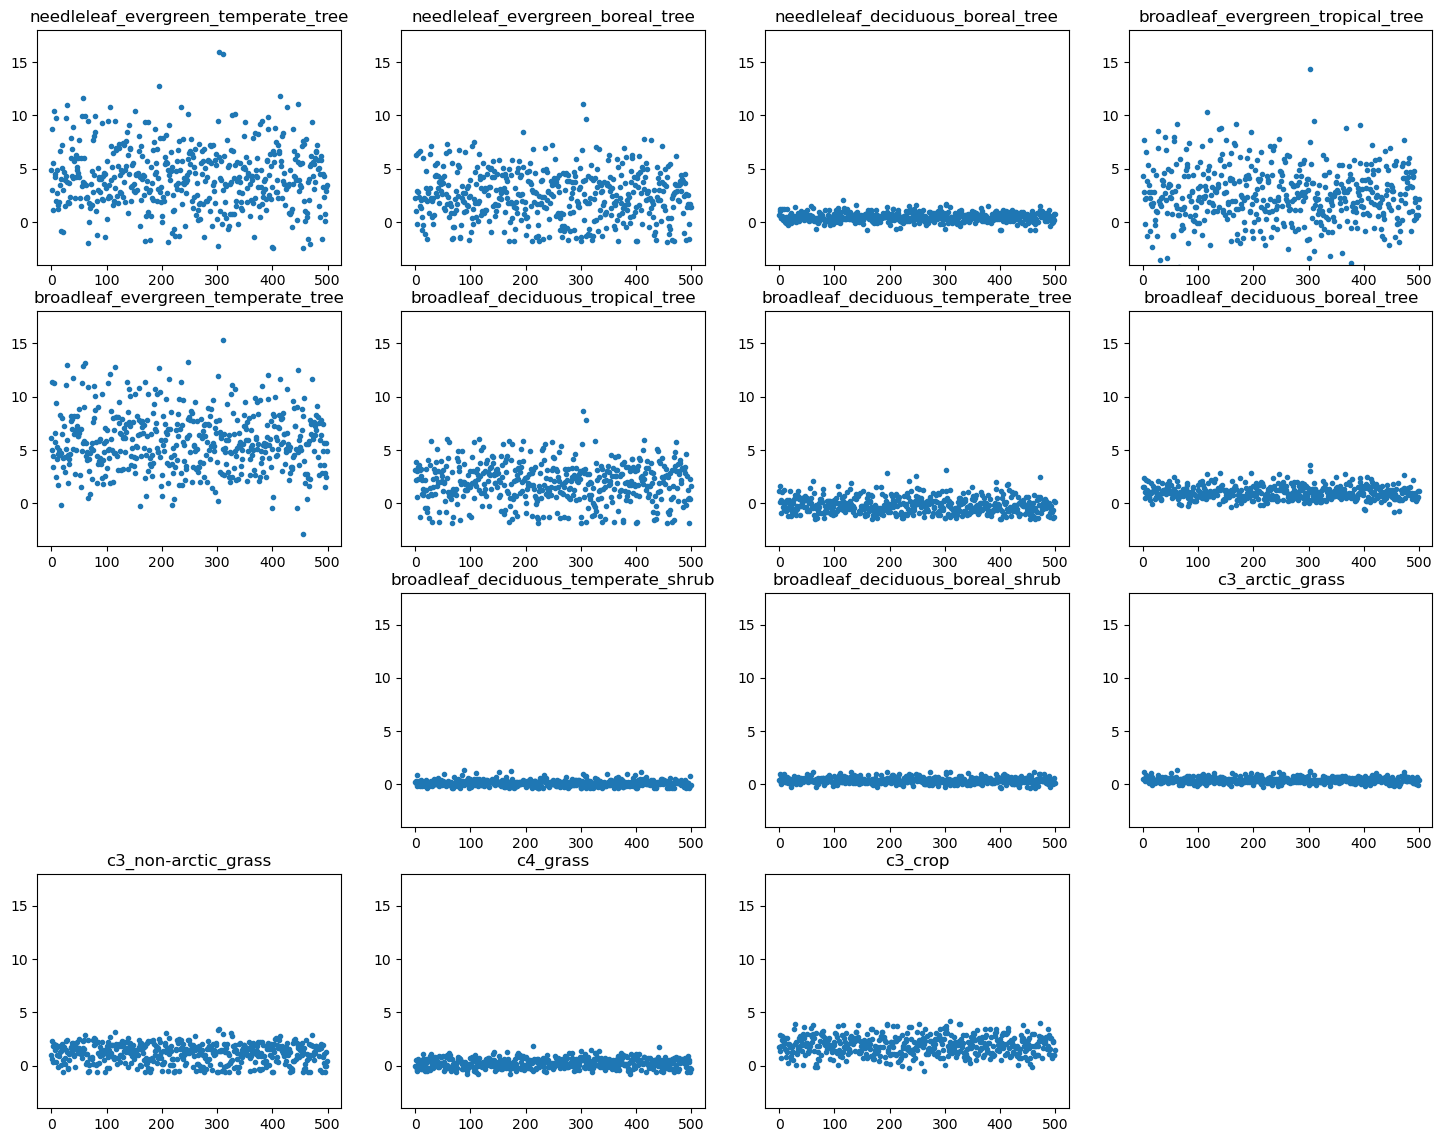

In [26]:
# view LAI error by PFT
# define target metric (error): sum(global mean annual mean PFT LAI error) 
# all pft's weighted equally

plt.figure(figsize=[18,14])
diff = []
for pft in [1,2,3,4,5,6,7,8,10,11,12,13,14,15]: #drop pft 9
    ax = plt.subplot(4,4,pft)
    err = pft_LAI.isel(pft=pft) - laisp[pft]
    diff.append(err)
    ax.plot(err,'.')
    ax.set_ylim([-4,18])
    ax.set_title(pfts[pft],fontsize = 12)

error = np.sum(diff,axis=0)

### Train Gaussian process Emulator

In [27]:
# some kernel options
kernel_linear = gpflow.kernels.Linear(active_dims=range(num_params),variance=1)
kernel_matern32 = gpflow.kernels.Matern32(active_dims=range(num_params), variance=1, lengthscales = np.tile(1,32))
kernel_matern52 = gpflow.kernels.Matern52(active_dims=range(num_params),variance=1,lengthscales=np.tile(1,32))
kernel_RBF = gpflow.kernels.RBF(active_dims = range(num_params), lengthscales=np.tile(1,num_params))

# Define kernel
kernel = kernel_linear + kernel_matern32

2023-03-15 17:24:26.311607: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-15 17:24:26.311667: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (crhtc52): /proc/driver/nvidia/version does not exist
2023-03-15 17:24:26.350944: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [30]:
var = normalize(error) # normalize the target metric before training emulator

n_test = 50 # number of ensemble members to test emulator
Y = var # target variable excluding default model [0]

X_test, X_train = ppe_params[:n_test], ppe_params[n_test:]
y_test, y_train = Y[:n_test], Y[n_test:]

PFTemulator = gp_model(np.array(X_train),np.array(y_train),kernel = kernel)
PFTemulator.train()

Text(0.5, 1.0, 'all pft error')

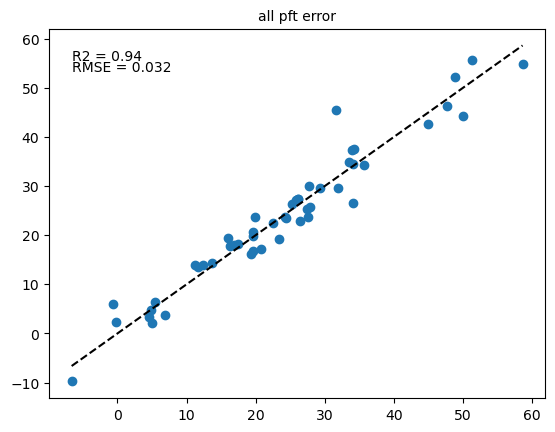

In [35]:
#plot emulator validation
y_pred, y_pred_var = PFTemulator.predict(X_test.values)

rms = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test,y_pred)

y_test_raw = unnormalize(y_test,error)

ax = plt.subplot(1,1,1)
ax.plot([min(y_test_raw),max(y_test_raw)],[min(y_test_raw),max(y_test_raw)],c='k',linestyle='--',label='1:1 line')
ax.scatter(y_test_raw,unnormalize(y_pred,error))
ax.text(min(y_test_raw),max(y_test_raw)*0.95,'R2 = '+str(np.round(r2,3)),fontsize=10)
ax.text(min(y_test_raw),max(y_test_raw)*0.91,'RMSE = '+str(np.round(rms,3)),fontsize=10)
ax.set_title('all pft error',fontsize = 10)

In [36]:
# sample parameter space and predict LAI using emulator
r1_sample = get_random_params(len(X_train.columns), 10000)
pred, _ = PFTemulator.predict(r1_sample)

In [37]:
ix = (pred>-0.05) & (pred<0.05) # set error threshold 
y_pred = pred[ix]
params_kept = pd.DataFrame(r1_sample[ix],columns = X_train.columns)

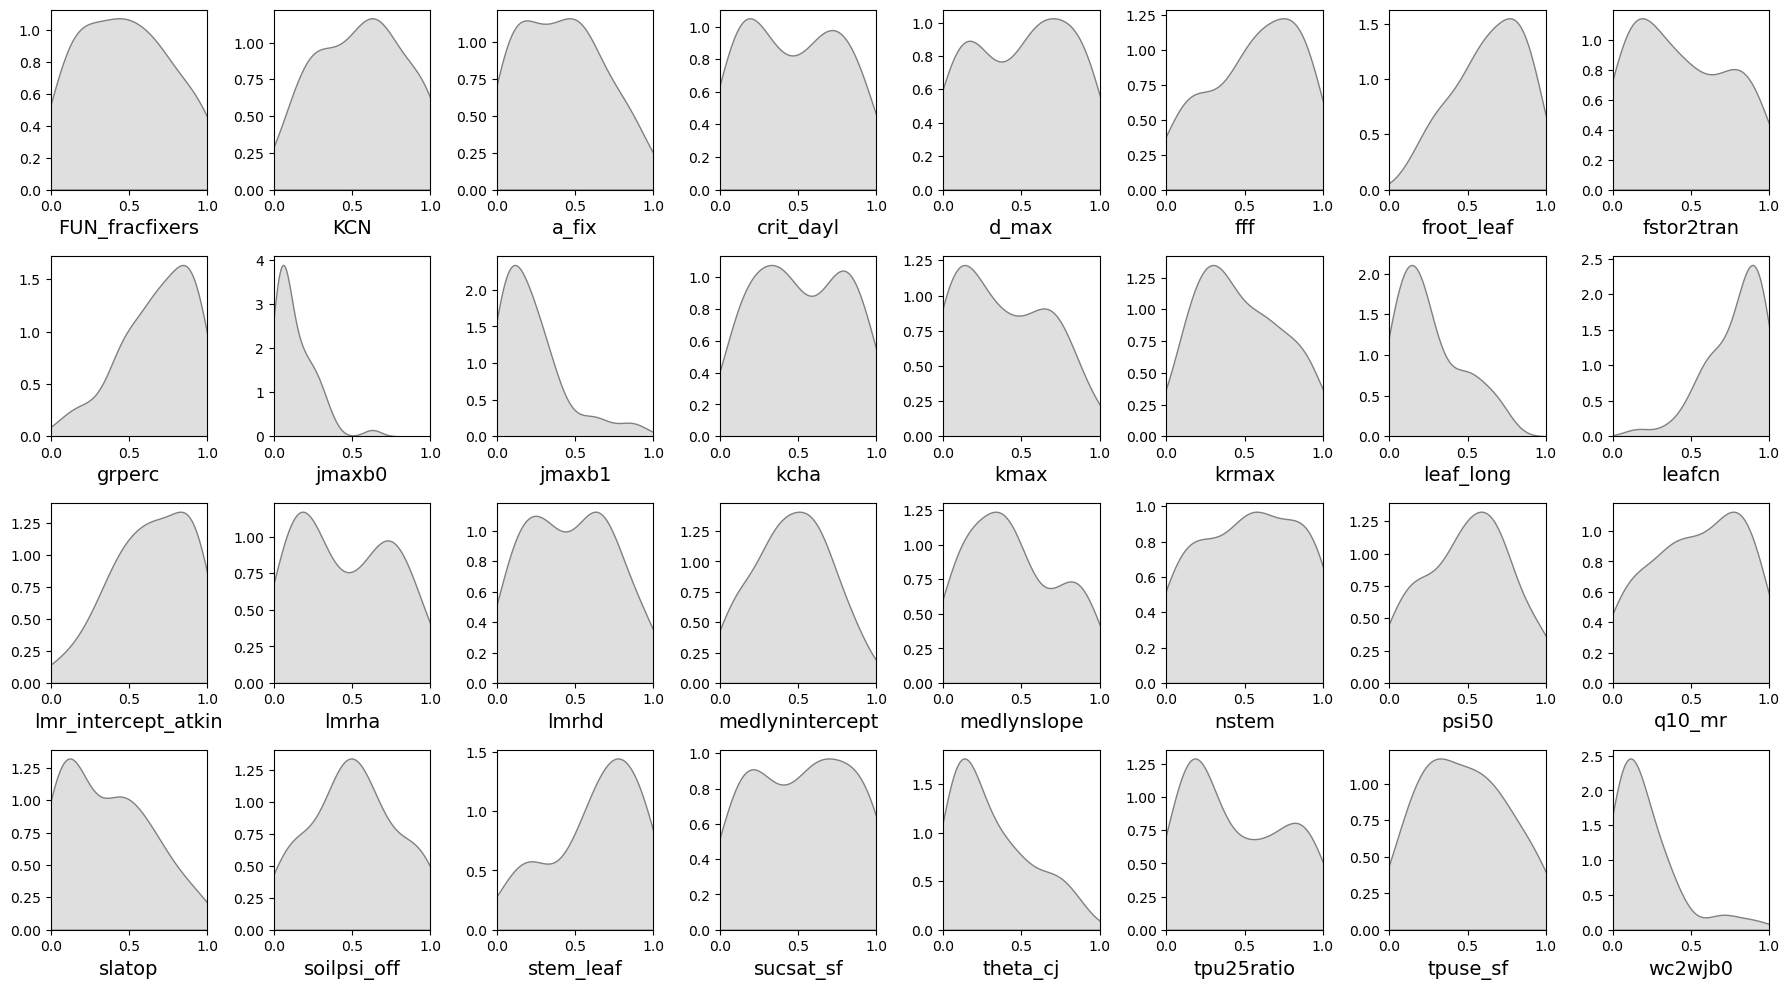

In [38]:
plt.figure(figsize=[18,10])
for p in range(num_params):
    plt.subplot(4,8,p+1)
    pname = ppe_params.columns[p]
    sns.distplot(params_kept[pname], hist = False, kde = True,
                kde_kws = {'shade': True, 'linewidth': 1, "color":"grey"},
                label='')
    plt.xlim([0,1])
    plt.ylabel('')
    plt.xlabel(pname,fontsize=14)
    #plt.legend()
plt.tight_layout()
#plt.savefig('../../figs/pft/posterior_allpfts_SPtarget.png')

### MCMC optimization

In [39]:
model = PFTemulator

In [40]:
target = xr.DataArray([0]) # minimize error

In [41]:
sampler = MCMCSampler(model,target)

In [28]:
samples = sampler.sample(n_samples=80000, kernel_kwargs = dict(step_size=0.005), mcmc_kwargs=dict(num_burnin_steps=5000))

Acceptance rate: 0.4067646772202637


In [29]:
# Get the emulated LAI error for these samples
Z, _ = model.predict(samples)

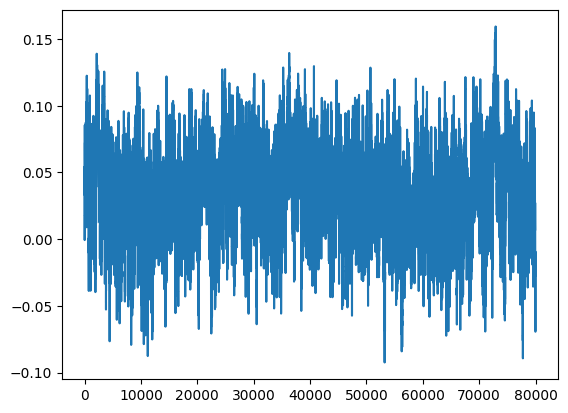

In [30]:
plt.plot(Z) #this should look like it converges

In [31]:
ix = (Z<0.01) & (Z>-0.01)
dfsamples = pd.DataFrame(samples[ix])
dfsamples.columns = ppe_params.columns

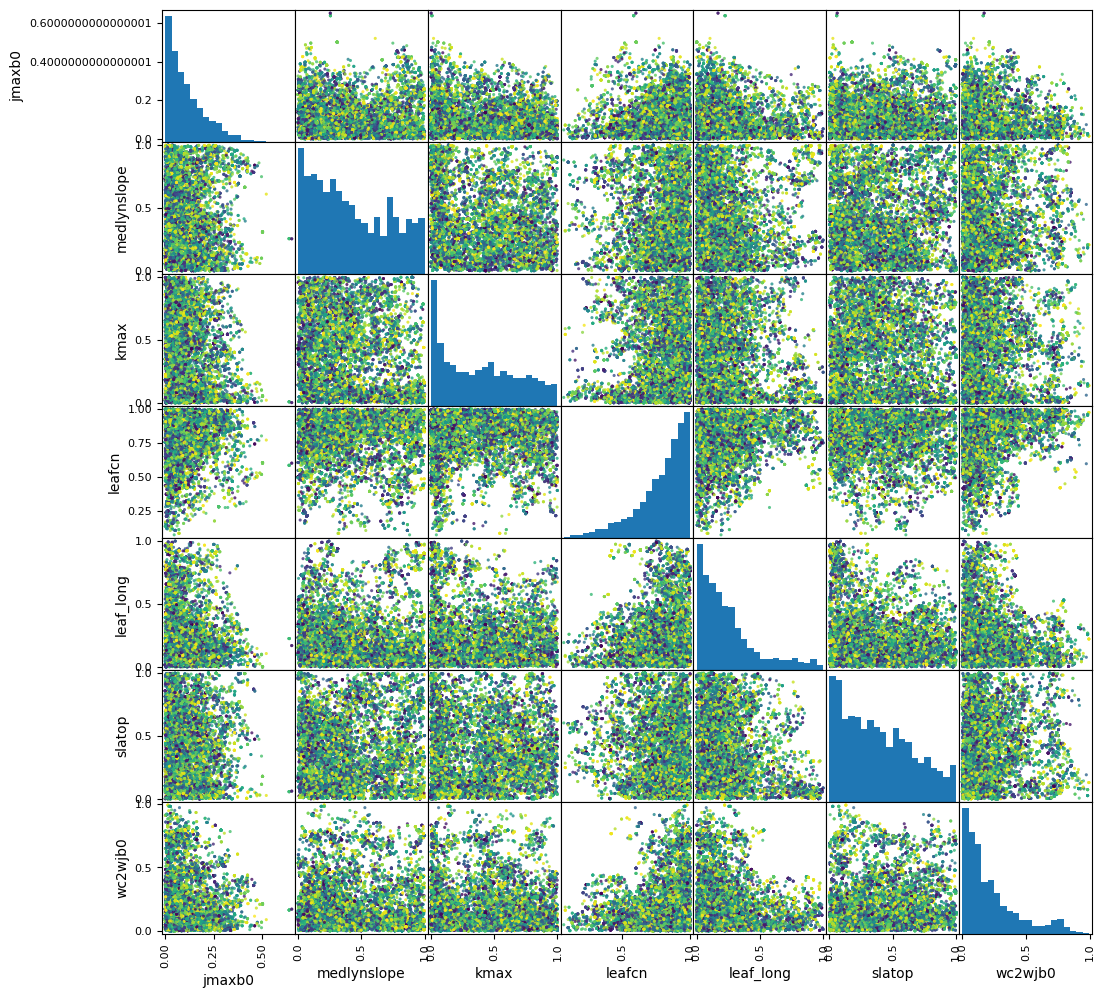

In [32]:
top_params = ['jmaxb0','medlynslope','kmax','leafcn','leaf_long','slatop','wc2wjb0']

grr = pd.plotting.scatter_matrix(dfsamples[top_params], c=Z[ix], figsize=(12, 12), marker='o',
                                 hist_kwds={'bins': 20}, s=5, alpha=.8)
